**Importing All the required libraries**

In [1]:
import numpy as np

!pip install mido
import mido

!pip install midiutil
from midiutil.MidiFile import MIDIFile

!pip install pretty_midi

import pretty_midi
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd

!pip install libfmp

import string

import os
import sys

from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import colors
import pretty_midi
import pandas as pd
import IPython.display as ipd

sys.path.append('..')
import libfmp.c1


     |████████████████████████████████| 51 kB 2.7 MB/s 
     |████████████████████████████████| 1.0 MB 1.9 MB/s 
  Created wheel for midiutil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54566 sha256=961d584eb19954318eca7049eaa0a4880157a9446856d90301fd4b018d2e57b3
  Stored in directory: /root/.cache/pip/wheels/e3/97/cd/a677b61a76d575f373e2e10302f1d9106507fea6dd1320df03
Successfully built midiutil
     |████████████████████████████████| 5.6 MB 4.2 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=9403f3e3822407c6fd081fc4b5597a0cc06c776c1f875bafe901816f4c27290f
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi
     |████████████████████████████████| 109 kB 4.3 MB/s 
     |████████████████████████████████| 786 kB 7.5 MB/s 
     |████████████████████████████████| 18.5 MB 74.7 MB/s 
     |████████████████████████████████| 368 kB 47.6 MB/s 
  Created 

**Forming functions for post processing**

In [2]:
def array_formation(arr):
  [x,y]= arr.shape

  arr2 = np.zeros((y,x,2), dtype=int)

  #Array to store the start and end times of each note played in key 
  start=1
  k=0 
  for j in range(arr.shape[1]):
     for i in range(arr.shape[0]):
          if arr[i,j]==1 and start==1:
              arr2[j,k,0]=i
              start=0
          elif arr[i,j]==0 and start==0:
              arr2[j,k,1]=i
              start=1
              k+=1
     k=0

  #Array to store the end times of each key 
  arr3=np.zeros((88), dtype=int)
  for i in range(arr2.shape[0]):
    for j in range(arr2.shape[1]):
      if arr2[i,j,0]==0:
        arr3[i]=j
        break
  return[arr2,arr3]

def pianoroll(path,plot):
  midi_data = pretty_midi.PrettyMIDI(path)
  midi_list = []

  pretty_midi.pretty_midi.MAX_TICK = 1e1000
  midi_data.tick_to_time(14325216)

  for instrument in midi_data.instruments:
      for note in instrument.notes:
          start = note.start
          end = note.end
          pitch = note.pitch
          velocity = note.velocity
          midi_list.append([start, end, pitch, velocity, instrument.name])
          
  midi_list = sorted(midi_list, key=lambda x: (x[0], x[2]))

  df = pd.DataFrame(midi_list, columns=['Start', 'End', 'Pitch', 'Velocity', 'Instrument'])

  time_list = df["End"].tolist()
  rows = len(time_list)

  if plot==True :

    fig, ax = plt.subplots()
    i = 0
    while(i<rows) :
        start = float(midi_list[i][0])
        pitch = float(midi_list[i][2])
        duration = float(midi_list[i][1]-midi_list[i][0])

        rect = matplotlib.patches.Rectangle((start, pitch),duration, 1, color='black', linewidth=0.5)
        ax.add_patch(rect)
        i+=1
        
    
    plt.xlim([0, 240])
    plt.ylim([0, 88])

    plt.grid(color='grey',linewidth=0.5)

    plt.show()
  
  stop_time=time_list[-1]
  return stop_time

def arr_to_midi(source_array,duration_array):
  mf = MIDIFile(1, deinterleave=False)
  track = 0   
  time = 0
  channel = 0
  volume = 100
  delta = t
  mf.addTrackName(track, time, "Output")
  mf.addTempo(track, time, 60)

  for i in range(source_array.shape[0]):
    for j in range(duration_array[i]):
              pitch = i +21
              time = delta*source_array[i,j,0]
              duration = delta*( source_array[i,j,1] - source_array[i,j,0] ) 
              mf.addNote(track, channel, pitch, time, duration, volume)

  with open("output.mid", 'wb') as outf:
      mf.writeFile(outf)

def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]
def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]
def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result
def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

def plot_colour_graph(path, title_plot):
  mid = mido.MidiFile(path, clip=True)
  result_array = mid2arry(mid)
  import matplotlib.pyplot as plt
  plt.axes([0, 0.6, 3, 1])
  plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
  plt.title(title_plot)
  plt.show()

def play_audio(path):
  fn = os.path.join(path)
  midi_data = pretty_midi.PrettyMIDI(fn)
  midi_list = []

  for instrument in midi_data.instruments:
   for note in instrument.notes:
    start = note.start
    end = note.end
    pitch = note.pitch
    velocity = note.velocity
    midi_list.append([start, end, pitch, velocity, instrument.name])
              
  midi_list = sorted(midi_list, key=lambda x: (x[0], x[2]))

  df = pd.DataFrame(midi_list, columns=['Start', 'End', 'Pitch', 'Velocity', 'Instrument'])
  html = df.to_html(index=False)
  ipd.HTML(html)

  Fs = 22050
  audio_data = midi_data.synthesize(fs=Fs)
  return audio_data


**Final Results**


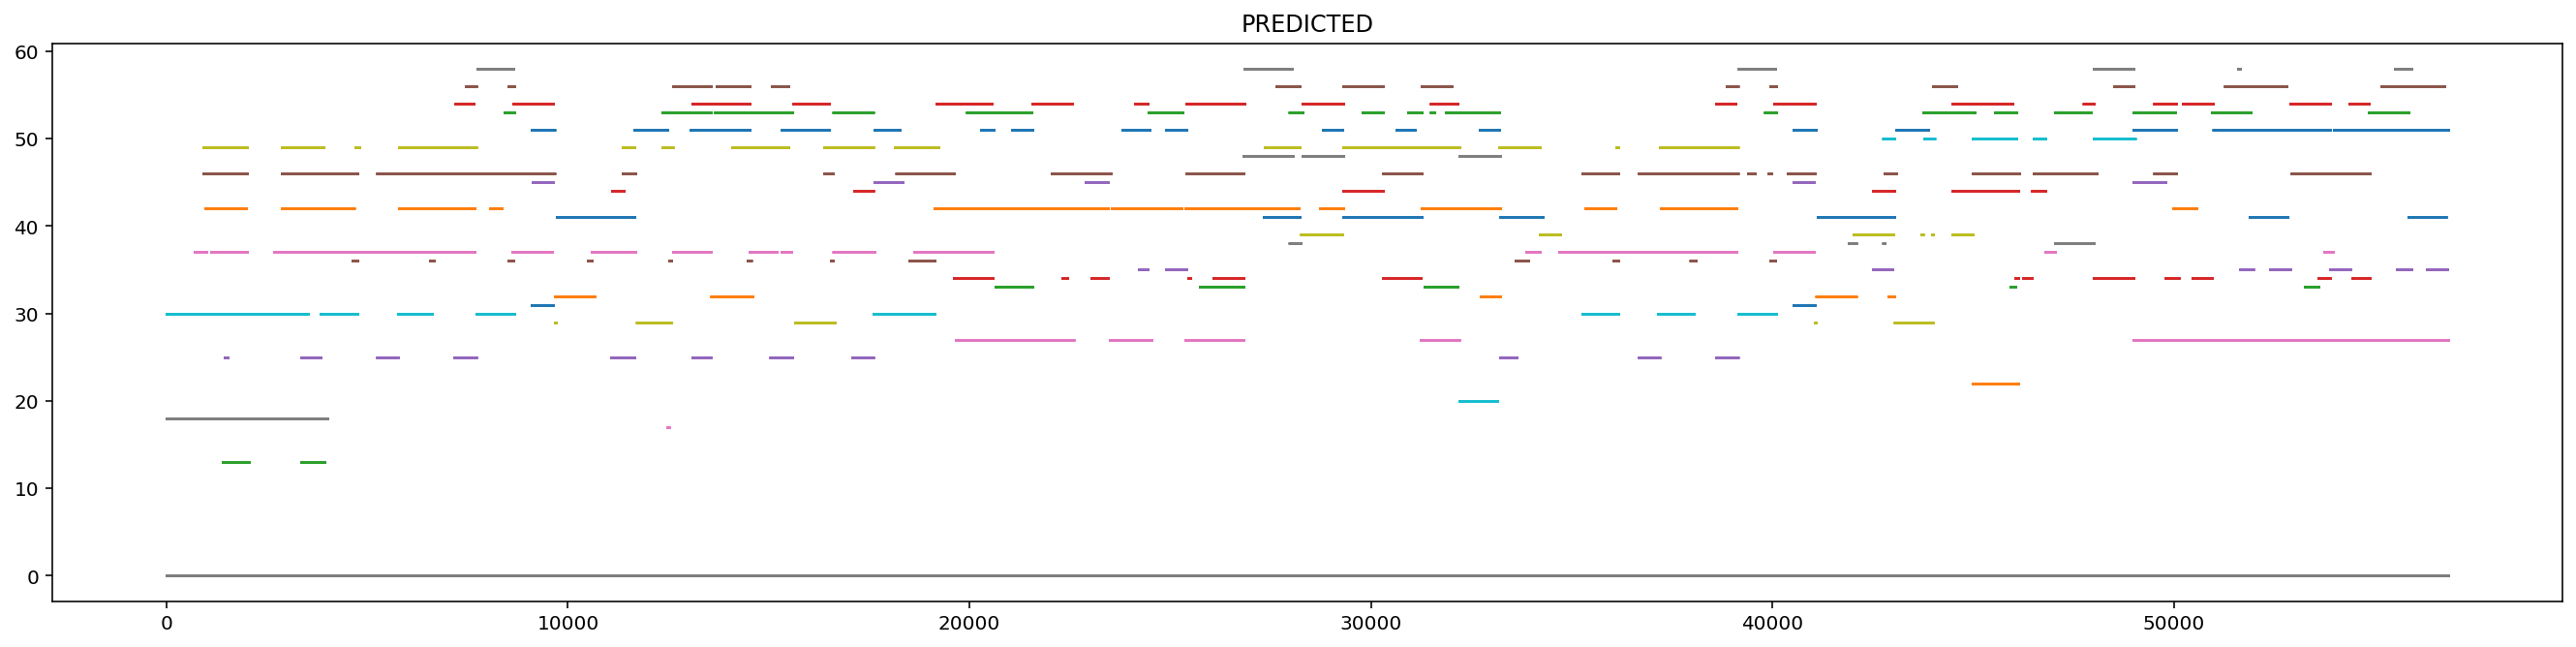

In [3]:
# This code takes a numpy array as input and gives out a piano midi file 'output.mid' and its corresponding piano roll
# Also, this code strictly works for a audio of 60s
# Enter the name of the predicted numpy file here:
Path_predicted_array='Output.npy'
predicted_array= np.load(Path_predicted_array)

# Here goes the code for showing results:
t=60/np.shape(predicted_array)[0]
arr_to_midi(array_formation(predicted_array)[0],array_formation(predicted_array)[1])
plot_colour_graph("output.mid", "PREDICTED") #This gives a colourful and elongated pianoroll representation


ipd.Audio(play_audio("output.mid"), rate=22050)